# Projecting the rsfMRI Signals Onto the PG Direction

In [44]:
from IPython.display import Image

## Principal gradient

*Margulies et al, PNAS, 2016*

<img src="img/PG_1.png" width="500" height="400"/>

Obtained by applying diffusion embedding (a nonlinear dimensionality reduction) to connectivity matrices

In [1]:
import numpy as np
from scipy import io
from scipy.io import savemat
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def loadMat(path,name):
    mat_file1 = io.loadmat(path)
    data = mat_file1[name]
    return data

def prctile(data,start,interval,end):
    prctile = np.array([])
    percentage = start
    while(percentage <= 100):
        prctile = np.append(prctile,np.percentile(data,percentage))
        percentage += interval
    return prctile

def grpstats(epi,pg1_70bins):
    max = np.max(pg1_70bins)
    min = np.min(pg1_70bins)
    result = np.empty((max-min+1 ,epi.shape[1]),object)
    nVtxInBin = np.zeros(max-min+1) # the number of vertices in each bin (1->70)
    for i in range(pg1_70bins.size):
        nVtxInBin[pg1_70bins[i][0]-1] +=1
        if(result[pg1_70bins[i][0]-1][0] == None):
            temp = epi[i,:]
        else:
            temp = result[pg1_70bins[i][0]-1,:] + epi[i,:]
        result[pg1_70bins[i][0]-1,:] = temp
    for j in range(max-min+1):
        result[j,:] = result[j,:]/ nVtxInBin[j]
    return result

def findPeaks(data):
    locs = find_peaks(data)[0]
    peak = np.array([])
    for i in range(locs.size):
        peak = np.append(peak,data[locs[i]]) 
    return peak,locs

def inpaintNans(array):
    if np.isnan(array[0]):
        array[0] = array[1]
    if np.isnan(array[-1]):
        array[-1] = array[-2]
    df = pd.DataFrame(array.astype(np.float)).interpolate()
    return df.to_numpy()

## Load data

- **pg1:** principal gradient 1 by Margulies et al, PNAS, 2016

- **epi:** rsfMRI -> spatially & temporally smoothed -> zscored data *(vertices * time points)*

In [2]:
path ="/hdd_ext/sdc/class/2021-2/advancedfMRI/data/human/test"

pg1 = loadMat(path+"/pg1","pg1") # Margulies et al, PNAS, 2016
epi = loadMat(path+"/epi1msk","epi1msk") # spatially & temporally smoothed -> zscored data (vertices * time points)

## Global mean signal

<img src="img/PG2.png" width="800" height="400"/>

Calculate **global mean signal** and identify **time segments** with a relatively large global positive peak amplitude

In [3]:
global_mean_sig = epi.mean(axis=0) # calculate the global mean of input data - Figure 1B middle graph
locs_seg_edge = find_peaks(-1 * global_mean_sig)[0] # cut the global mean signal into time segments - Figure 1B middle graph
                                                    # locs_seg_edge: location of negative peaks - indicate edge time points of time segments

## Time-position plot

<img src="img/PG3.png" width="800" height="400"/>

1. **Sort** 59412 cortical surface vertices **according to the PG**

2. Divide vertices into 70 position bins of equal size

3. Average the fMRI signals within each position bin

4. Do the 3rd step again with randomly shuffled position bins

<img src="img/PG4.png" width="800" height="400"/>

In [4]:
# time-position plot

pg1_70bins = np.digitize(pg1, prctile(pg1,0,100/70,100)) # divide pg1 vertices into 70 bins (vertices * 1 - the value in each row indicates which bin the vertex belongs to)
pg1_70bins = pg1_70bins-np.min(pg1_70bins)+1 # make sure that pg1_70bins values are in 1~70

# randomly rotated PG
rand_idx = np.random.permutation(pg1_70bins.shape[0])
pg1_70bins_rand = pg1_70bins[rand_idx.T]

time_pos = grpstats(epi, pg1_70bins)  # % the time-position plot (time_pos) along the brain map (postion(70) * time(1200)) - Figure 1B upper graph
time_pos_rand = grpstats(epi,pg1_70bins_rand) 

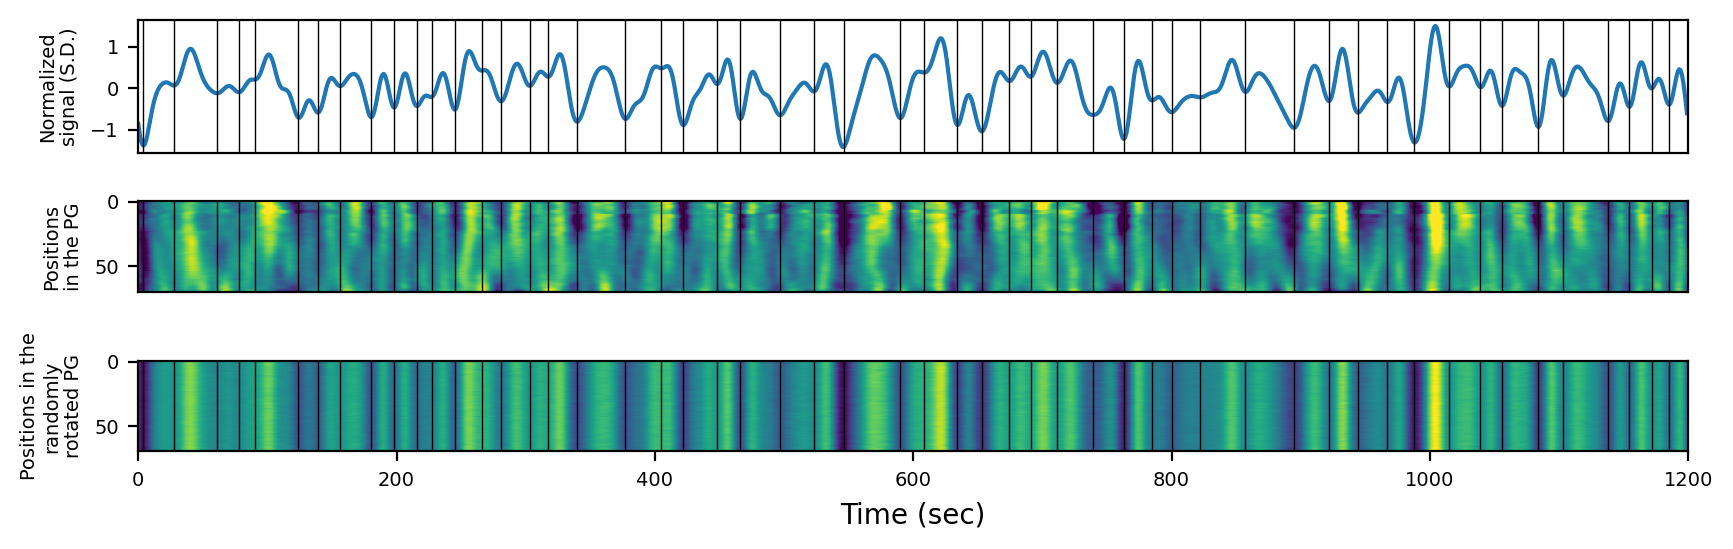

In [5]:
font_small = 7

fig, ax = plt.subplots(3, 1)

fig.set_size_inches(10,3)
fig.patch.set_facecolor('white')
fig.set_dpi(200)

# global mean signal graph
ax[0].plot(np.arange(global_mean_sig.shape[0]), global_mean_sig)
ax[0].set_ylabel('Normalized\nsignal (S.D.)', fontsize=font_small)
ax[0].set_xlim(0, 1200)
ax[0].tick_params (axis = 'y', labelsize = font_small)
ax[0].get_xaxis().set_visible(False)
for i in range(locs_seg_edge.shape[0]):
    loc_now = locs_seg_edge[i]
    ax[0].axvline(x=loc_now, color='k', linewidth=0.5)
    
# time-position graph
ax[1].imshow(time_pos.astype(np.float), vmin=-1.5, vmax=1.5)
ax[1].set_ylabel('Positions\nin the PG', fontsize=font_small)
ax[1].set_xlim(0, 1200)
ax[1].tick_params (axis = 'y', labelsize = font_small)
ax[1].get_xaxis().set_visible(False)
for i in range(locs_seg_edge.shape[0]):
    loc_now = locs_seg_edge[i]
    ax[1].axvline(x=loc_now, color='k', linewidth=0.5)
    
# time-position graph - randomly rotated PG
pos = ax[2].imshow(time_pos_rand.astype(np.float), vmin=-1.5, vmax=1.5)
ax[2].set_ylabel('Positions in the\nrandomly\nrotated PG', fontsize=font_small)
ax[2].set_xlim(0, 1200)
ax[2].tick_params (axis = 'y', labelsize = font_small)
ax[2].tick_params (axis = 'x', labelsize = font_small)
for i in range(locs_seg_edge.shape[0]):
    loc_now = locs_seg_edge[i]
    ax[2].axvline(x=loc_now, color='k', linewidth=0.5)
    
#plt.colorbar(pos, ax=ax[2], orientation='horizontal')

plt.xlabel('Time (sec)')
plt.show()

<img src="img/PG4.png" width="900" height="400"/>

## Find local peaks at each position

<img src="img/PG5.png" width="500" height="400"/>

1. **Time segmentation** based on the troughs of the global mean signal

2. Find a **local peak for each position** bin within each time segment

In [6]:
idx_peak_seg = np.zeros((time_pos.shape[0], locs_seg_edge.shape[0]-1),object) # position * segment

for li in np.arange(locs_seg_edge.shape[0]-1): 
    tmp_seg = np.array([])
    tmp_seg = epi[:,locs_seg_edge[li]:locs_seg_edge[li+1]] # get one time segment

    for lj in np.arange(time_pos.shape[0]): 
        tmp_pos = tmp_seg[lj,:] # get one position
        value_pos_peak, locs_pos_peak = findPeaks(tmp_pos)  # and find peak of that position - Figure 1C red line
                                                            # value_pos_peak: the value of each peak
                                                            # locs_pos_peak: index of the peak
        threshold = 0       

        # find a peak in each segment - Figure 1C red line

        if locs_pos_peak.size == 0: # no peak
            idx_peak_seg[lj,li] = np.NaN; 

        elif locs_pos_peak.shape[0] > 1: # if more than one peaks exist
            value_max = np.max(value_pos_peak) # pick just one peak that has the highest value
            idx_max = np.argmin(value_pos_peak)

            if value_max <= threshold: # if the peak value is lower than the threshold value, make it nan
                idx_peak_seg[lj,li] = np.NaN; 

            else: # save the index of the peak only if the value is above the threshold
                idx_peak_seg[lj,li] = locs_pos_peak[idx_max]

        elif value_pos_peak > threshold: # one peak, and above the threshold -> save the index
            idx_peak_seg[lj,li] = locs_pos_peak[0]

        else:
            idx_peak_seg[lj,li] = np.NaN; 


## Time-position correlation

<img src="img/PG6.png" width="900" height="400"/>

Calculate the Pearson's correlation between the timing and position of local peaks of all the position bins

In [19]:
# calculate time-position correlation at each segment: r_time_pos (Figure 1C r value, Figure 1D Principal gradient(PG) graph)

sz = np.diff(locs_seg_edge) # width of each segment
r_time_pos = np.zeros((1,locs_seg_edge.shape[0]-1),object) # 1 * segments

for ln in np.arange(locs_seg_edge.shape[0]-1):

    pos = np.arange(70) # 70 positions

    if np.sum(np.isnan(idx_peak_seg[:,ln].astype(np.float))) > 14: # if more than 14 peak indices in each time point are nan,
        r_time_pos[:,ln] = np.NaN # correlation of that time point is nan

    else: # if not, calculate time-position correlation at each segment - Figure 1C r value   
        r_time_pos[:,ln] = np.corrcoef(pos, idx_peak_seg[:,ln].astype(np.float))[0,1]

In [20]:
max_seg = np.argmax(r_time_pos) # highest positive correlation segment - top-down
min_seg = np.argmin(r_time_pos) # highest negative correlation segment - bottom-up

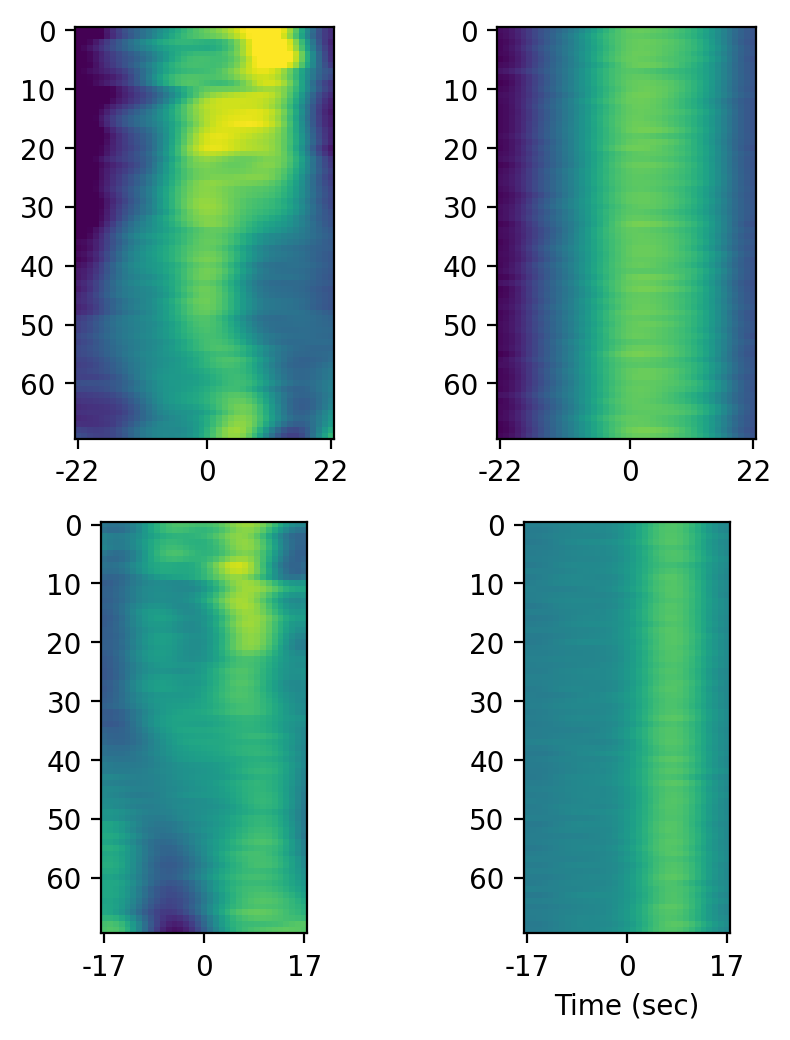

In [41]:
font_small = 7

fig, ax = plt.subplots(2, 2)

fig.set_size_inches(5,6)
fig.patch.set_facecolor('white')
fig.set_dpi(200)

   
# time-position graph
ax[0,0].imshow(time_pos.astype(np.float)[:, locs_seg_edge[max_seg]:locs_seg_edge[max_seg+1]], vmin=-1.5, vmax=1.5)
#ax[0,0].plot(idx_peak_seg[max_seg])
ax[0,0].xaxis.set_ticks([0, 22, 43])
ax[0,0].xaxis.set_ticklabels([-22, 0, 22])
# ax[1].set_ylabel('Positions\nin the PG', fontsize=font_small)
#ax[0,0].set_xlim(-10, 10)
# ax[1].tick_params (axis = 'y', labelsize = font_small)
# ax[1].get_xaxis().set_visible(False)
# for i in range(locs_seg_edge.shape[0]):
#     loc_now = locs_seg_edge[i]
#     ax[1].axvline(x=loc_now, color='k', linewidth=0.5)

ax[0,1].imshow(time_pos_rand.astype(np.float)[:, locs_seg_edge[max_seg]:locs_seg_edge[max_seg+1]], vmin=-1.5, vmax=1.5)
ax[0,1].xaxis.set_ticks([0, 22, 43])
ax[0,1].xaxis.set_ticklabels([-22, 0, 22])

ax[1,0].imshow(time_pos.astype(np.float)[:, locs_seg_edge[min_seg]:locs_seg_edge[min_seg+1]], vmin=-1.5, vmax=1.5)
ax[1,0].xaxis.set_ticks([0, 17, 34])
ax[1,0].xaxis.set_ticklabels([-17, 0, 17])

ax[1,1].imshow(time_pos_rand.astype(np.float)[:, locs_seg_edge[min_seg]:locs_seg_edge[min_seg+1]], vmin=-1.5, vmax=1.5)
ax[1,1].xaxis.set_ticks([0, 17, 34])
ax[1,1].xaxis.set_ticklabels([-17, 0, 17])

    
#plt.colorbar(pos, ax=ax[2], orientation='horizontal')

plt.xlabel('Time (sec)')
plt.show()

## Histogram of time-position correlation

<img src="img/PG7.png" width="900" height="400"/>

- time segments with correlations close to +1: bottom-up

- time segments with correlations close to -1: top-down

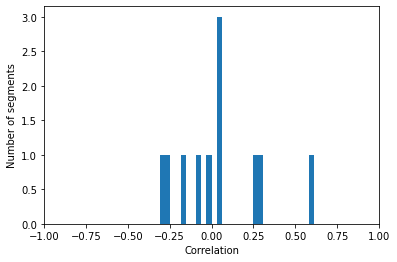

In [18]:
# histogram (Figure 1D Principal gradient(PG) graph)

r_time_pos = r_time_pos.astype(np.float)
r_time_pos = r_time_pos[~np.isnan(r_time_pos)] # remove nans

plt.hist(r_time_pos,bins=30)
plt.xlim([-1, 1])
plt.xlabel('Correlation')
plt.ylabel('Number of segments')
plt.show()